##Notebook created by: Austin Copley (acopley@umass.edu) and Abdul Aziz (abdulaziz@umass.edu) for COMPSCI 528: Ubiquitous and Mobile Computing (Fall 2024)

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from glob import glob
import random
import joblib

In [2]:
classes = ["UP","DOWN","LEFT","RIGHT","CLOCKWISE","REST","FORWARD","BACKWARD"]
#classes = ["UP","DOWN","LEFT","RIGHT"]
train_files = []
val_files = []
test_files = []

for i in range(len(classes)):
    files = glob(f"Data/{classes[i]}_*")
    files = [f for f in files if os.path.basename(f).startswith(f"{classes[i]}_")]
    print(classes[i],len(files))
    random.shuffle(files)
    
    train_files.extend(files[:15])
    val_files.extend(files[15:17])
    test_files.extend(files[17:])
    


UP 20
DOWN 20
LEFT 20
RIGHT 20
CLOCKWISE 20
REST 20
FORWARD 20
BACKWARD 20


In [3]:
len(train_files),len(val_files),len(test_files)

(120, 16, 24)

In [4]:
new_classes = ["up_data","Down_data","Left_data","Right_data","clockwise","anticlockwise","rest","Forward","Backward"]
#new_classes = ["up_data","Down_data","Left_data","Right_data"]
for i in range(len(new_classes)):
    files = glob(f"Data/data_files/{new_classes[i]}/*")
    #files = [f for f in files if os.path.basename(f).startswith(f"{new_classes[i]}_")]
    print(new_classes[i],len(files))
    random.shuffle(files)
    train_files.extend(files[:15])
    val_files.extend(files[15:17])
    test_files.extend(files[17:])

up_data 21
Down_data 21
Left_data 21
Right_data 21
clockwise 21
anticlockwise 21
rest 0
Forward 20
Backward 20


In [5]:
len(train_files),len(val_files),len(test_files)

(255, 34, 57)

In [6]:
new_classes_v2 = ["up","down","left","right","clockwise","anticlockwise","rest","fwd","bwd"]
#new_classes_v2 = ["up","down","left","right"]
for i in range(len(new_classes_v2)):
    files = glob(f"Data/{new_classes_v2[i]}_*")
    files = [f for f in files if os.path.basename(f).startswith(f"{new_classes_v2[i]}_")]
    print(new_classes_v2[i],len(files))
    random.shuffle(files)
    train_files.extend(files[:15])
    val_files.extend(files[15:17])
    test_files.extend(files[17:])

up 20
down 20
left 20
right 20
clockwise 0
anticlockwise 0
rest 0
fwd 20
bwd 20


In [7]:
len(train_files),len(val_files),len(test_files)

(345, 46, 75)

In [4]:
train_files

['Data\\UP_gesture_data_14.csv',
 'Data\\UP_gesture_data_11.csv',
 'Data\\UP_gesture_data_17.csv',
 'Data\\UP_gesture_data_13.csv',
 'Data\\UP_gesture_data_4.csv',
 'Data\\UP_gesture_data_1.csv',
 'Data\\UP_gesture_data_10.csv',
 'Data\\UP_gesture_data_20.csv',
 'Data\\UP_gesture_data_2.csv',
 'Data\\UP_gesture_data_5.csv',
 'Data\\UP_gesture_data_6.csv',
 'Data\\UP_gesture_data_3.csv',
 'Data\\UP_gesture_data_12.csv',
 'Data\\UP_gesture_data_7.csv',
 'Data\\UP_gesture_data_9.csv',
 'Data\\DOWN_gesture_data_5.csv',
 'Data\\DOWN_gesture_data_15.csv',
 'Data\\DOWN_gesture_data_10.csv',
 'Data\\DOWN_gesture_data_18.csv',
 'Data\\DOWN_gesture_data_12.csv',
 'Data\\DOWN_gesture_data_8.csv',
 'Data\\DOWN_gesture_data_6.csv',
 'Data\\DOWN_gesture_data_9.csv',
 'Data\\DOWN_gesture_data_13.csv',
 'Data\\DOWN_gesture_data_17.csv',
 'Data\\DOWN_gesture_data_19.csv',
 'Data\\DOWN_gesture_data_16.csv',
 'Data\\DOWN_gesture_data_11.csv',
 'Data\\DOWN_gesture_data_3.csv',
 'Data\\DOWN_gesture_data_4.

In [5]:
def load_data(files,fixed_length):
    features,labels = [],[]
    csv = True
    for file in files:
        if ".csv" in file:
            label = file.split("_")[0].split("\\")[1]
            df = pd.read_csv(file)
            csv = True
        else:
            print(file)
            csv = False
            label = file.split("/")[2].split("\\")[0]
            with open(file, 'r') as file:
                lines = file.readlines()
            
            # Split lines into header and data
            header = lines[0].strip().split("\t")  # Assuming tab-separated values
            header = [head.strip() for head in header]
            data = [line.strip().split("\t") for line in lines[1:]]  # Skip header row

            # Convert data to a pandas DataFrame
            df = pd.DataFrame(data, columns=header)

        df[['gyro_x', 'gyro_y', 'gyro_z', 'acce_x', 'acce_y', 'acce_z']] = df[
            ['gyro_x', 'gyro_y', 'gyro_z', 'acce_x', 'acce_y', 'acce_z']
        ].apply(pd.to_numeric, errors='coerce')
        
        # Drop rows with any NaN values in the specified columns
        df = df.dropna(subset=['gyro_x', 'gyro_y', 'gyro_z', 'acce_x', 'acce_y', 'acce_z'])

        # Convert to numpy and normalize if there are any valid rows left
        if not df.empty:
            data = df[['gyro_x', 'gyro_y', 'gyro_z', 'acce_x', 'acce_y', 'acce_z']].values.astype(np.float32)
            data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))  # Normalize data
            
            if len(data) > fixed_length:
                data = data[:fixed_length]  # truncate if longer than fixed length
            elif len(data) < fixed_length:
                padding = np.zeros((fixed_length - len(data), data.shape[1]), dtype=np.float32)
                data = np.vstack((data, padding)) 
                
            features.append(data.flatten())
            if(csv):
                if label in classes:
                    labels.append(classes.index(label))
                else:
                    labels.append(new_classes_v2.index(label))
            else:
                labels.append(new_classes.index(label))
        
    return np.array(features), np.array(labels)

In [6]:
X_train, y_train = load_data(train_files,400)
X_val, y_val = load_data(val_files,400)
X_test, y_test = load_data(test_files,400)

In [7]:
X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

((120, 2400), (120,), (16, 2400), (16,), (24, 2400), (24,))

In [8]:
def train_and_evaluate_svm(X_train, y_train, X_val, y_val,X_test, y_test):
    # Create the SVM classifier
    svm_classifier = SVC(kernel='rbf')

    # Train the classifier
    svm_classifier.fit(X_train, y_train)
    joblib.dump(svm_classifier, "Trained_model/svm_model.pkl")

    # Perform prediction on the test set
    y_val_pred = svm_classifier.predict(X_val)
    

    # Evaluate the model
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f'SVM validation accuracy: {accuracy:.3%}')
    
    y_test_pred = svm_classifier.predict(X_test)
    

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_test_pred)
    print(f'SVM testing accuracy: {accuracy:.3%}')

    # Plot the confusion matrix
    conf_matrix_val = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_val, annot=True, cmap="Blues", fmt='g')
    plt.title('Validation Set Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Testing set heatmap
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_test, annot=True, cmap="Blues", fmt='g')
    plt.title('Testing Set Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

SVM validation accuracy: 100.000%
SVM testing accuracy: 83.333%


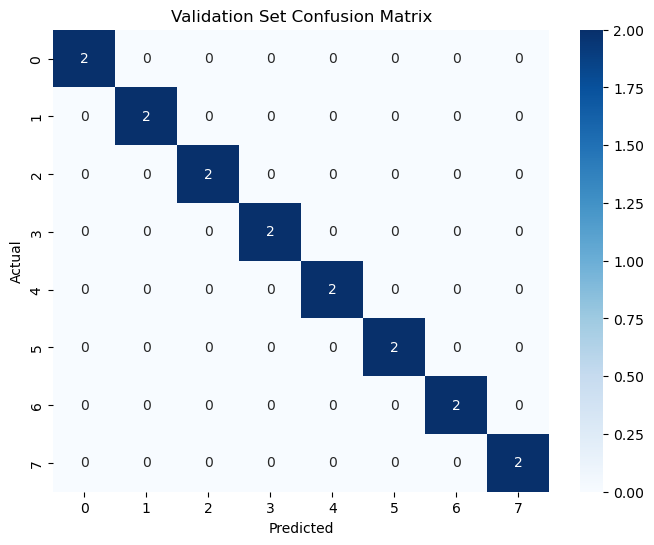

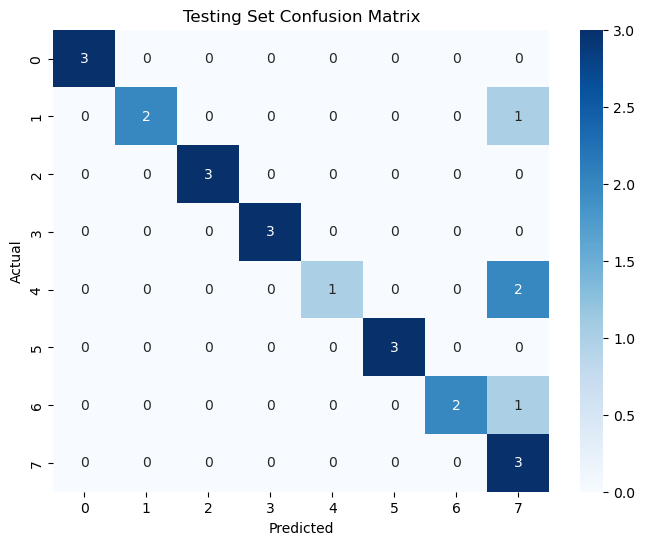

In [9]:
train_and_evaluate_svm(X_train, y_train, X_val, y_val,X_test, y_test)

In [10]:
def train_and_evaluate_knn(X_train, y_train, X_val, y_val,X_test, y_test, n_neighbors=3):
    # Create the SVM classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Train the classifier
    knn_classifier.fit(X_train, y_train)
    joblib.dump(knn_classifier, "Trained_model/knn_model.pkl")
    # Perform prediction on the test set
    y_val_pred = knn_classifier.predict(X_val)

    # Evaluate the model
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f'KNN validation accuracy: {accuracy:.3%}')
    
    y_test_pred = knn_classifier.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_test_pred)
    print(f'KNN testing accuracy: {accuracy:.3%}')

    # Plot the confusion matrix
    conf_matrix_val = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_val, annot=True, cmap="Blues", fmt='g')
    plt.title('Validation Set Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Testing set heatmap
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_test, annot=True, cmap="Blues", fmt='g')
    plt.title('Testing Set Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

KNN validation accuracy: 87.500%
KNN testing accuracy: 87.500%


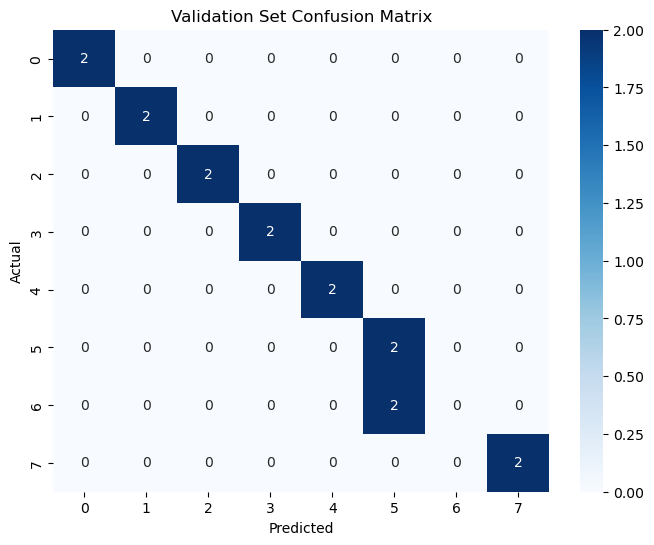

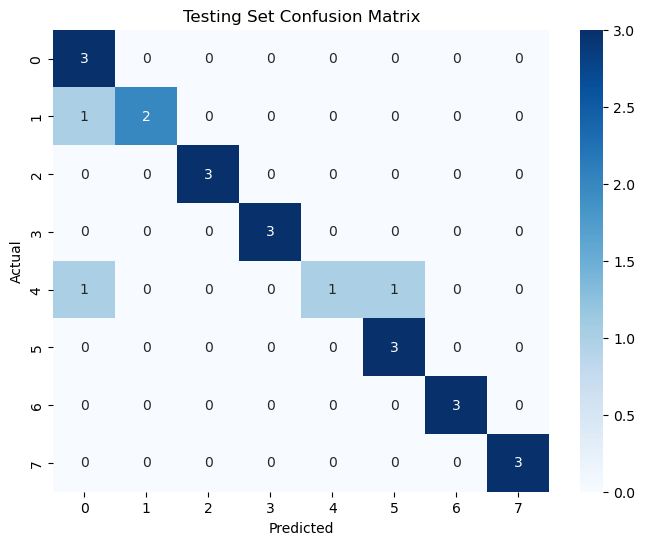

In [11]:
train_and_evaluate_knn(X_train, y_train, X_val, y_val,X_test, y_test)